# Predicting NBA All-Star Appearances with Player Measurements

Scouts have mentioned taking a closer look at player wingspan when drafting prospects. Kevin Durant admitted his long wingspan helped him on defense. Draymond Green and Rudy Gobert admitted their long wingspan helped them stay in the league for their excellent defense. The Milwaukee Bucks used wingspan to draft Thon Maker, but traded him in 2019 as Maker couldn't break out into a defensive stud. But this raises an interesting question: can wingspan predict All-Star appearances? 

Data was extracted using the NBA_Measurements_Value_Scraper. Both Selenium and Beautiful Soup were used to extract data, with multhreading used to speed up the process. The values are stored in a csv file called NBA_Measurements_Value_Added.csv. For this analysis, we'll read from this file.

## Data Extraction and Cleaning

In [1]:
import pandas as pd
import numpy as np

In [2]:
NBA_MVA_df = pd.read_csv("NBA_Measurements_Value_Added.csv").dropna()
NBA_MVA_df = NBA_MVA_df.drop(['Unnamed: 0'], axis=1)
NBA_MVA_df = NBA_MVA_df[NBA_MVA_df.WINGSPAN > 50]
NBA_MVA_df = NBA_MVA_df[NBA_MVA_df.WEIGHT != '-']
NBA_MVA_df['WEIGHT'] = pd.to_numeric(NBA_MVA_df['WEIGHT'] , downcast='float')
NBA_MVA_df = NBA_MVA_df[NBA_MVA_df.WEIGHT > 0]

NBA_MVA_df['STANDING REACH'] = pd.to_numeric(NBA_MVA_df['STANDING REACH'] , downcast='float')
NBA_MVA_df['HEIGHT'] = pd.to_numeric(NBA_MVA_df['HEIGHT'] , downcast='float')
NBA_MVA_df['VA'] = pd.to_numeric(NBA_MVA_df['VA'] , downcast='float')
NBA_MVA_df['WINGSPAN'] = pd.to_numeric(NBA_MVA_df['WINGSPAN'] , downcast='float')


NBA_MVA_df= NBA_MVA_df.reset_index()
NBA_MVA_df = NBA_MVA_df.drop(['index'], axis=1)

In [3]:
NBA_MVA_df.head(15)

,PLAYER,VA,ALL-STAR,BODY FAT,HEIGHT,STANDING REACH,WEIGHT,WINGSPAN
0,Rudy Gobert,538.400024,0.0,4.40%,84.50,115.0,237.600006,92.50
1,Jordan Clarkson,192.899994,0.0,4.30%,75.25,98.0,186.300003,80.00
2,Darren Collison,183.699997,0.0,5.70%,72.25,96.5,166.199997,75.00
3,Klay Thompson,245.500000,1.0,8.00%,77.75,103.5,205.600006,81.00
4,Khris Middleton,216.100006,1.0,7.80%,78.75,103.0,216.199997,82.75
5,Trey Burke,92.900002,0.0,6.90%,71.75,97.5,187.000000,77.50
6,T.J. Warren,119.000000,0.0,7.95%,79.00,104.0,220.199997,82.25
7,Spencer Dinwiddie,151.899994,0.0,5.35%,76.50,103.0,204.899994,80.25
8,Monte Morris,155.699997,0.0,6.90%,73.25,96.5,175.199997,76.00
9,Thaddeus Young,177.500000,0.0,4.90%,77.75,106.0,210.000000,83.50


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


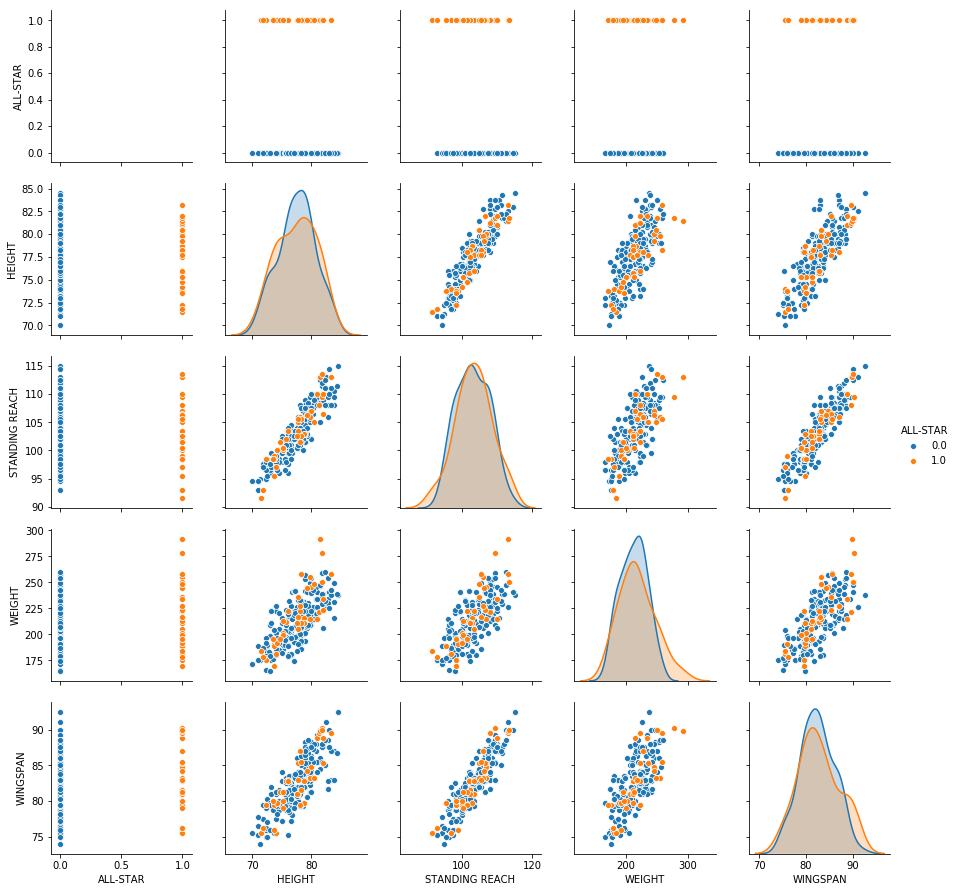

In [5]:
sns.pairplot(NBA_MVA_df[['ALL-STAR', 'HEIGHT', 'STANDING REACH', 'WEIGHT', 'WINGSPAN']], hue="ALL-STAR")

If we look at the KDE plots for Height, Standing Reach, Weight, and Wing Span, All-Stars and non All-Stars share very similar statistics. It would be very difficult to select a classification algorithm to predict an All-Star based on body measurements. There doesn't seem to be a strong difference between All-Stars and regular players on body measurements. 

We will attempt to do so using two methods

    1) Use Random Forest Classification to predict All-Stars based on Wingspan and Height. Bob Meyers once said that the perfect NBA player must be 6ft 8 inches tall with a 7ft 6 inches wingspan (assuming the player can score).
    
    2) Use PCA to map Height, Standing Reach, Weight, and WingSpan to 2 components. Use Random Forest Classification to predict All-Stars based on all those measurements. 


## Random Forest Classification with Wingspan and Height

In [6]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(NBA_MVA_df[['WINGSPAN', 'HEIGHT']], NBA_MVA_df['ALL-STAR'], test_size = 0.25, random_state = 0)


# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)


/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


In [7]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

[[44  6]
 [ 5  2]]
(0.8183852488363766, 0.8070175438596491, 0.8124756335282652, None)


The F-score is close to 1, making this a really good model. The confusion matrix 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


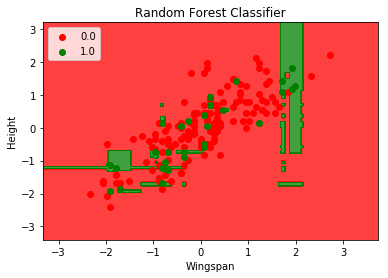

In [10]:
# Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Random Forest Classifier')
plt.xlabel('Wingspan')
plt.ylabel('Height')
plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


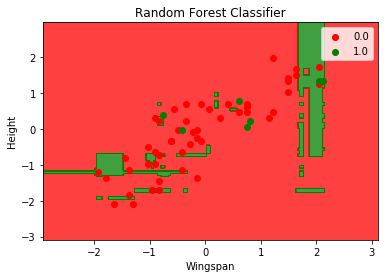

In [11]:
# Visualising the Test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Random Forest Classifier')
plt.xlabel('Wingspan')
plt.ylabel('Height')
plt.legend()
plt.show()

Is Bob Meyer's right? That the perfect NBA player must be 6ft 8 inches tall with a 7ft 6 inches wingspan? Let's use the Random Forest Classifier and predict whether an All-Star is from those measurements. 

In [14]:
#Predict Ideal Measurements : 6ft 8 inches  height with a 7ft 6 inches wingspan
print(classifier.predict(sc.transform([[90,80]])))

[1.]


All Stars are 1 by our classifier. So Bob Meyer's is right by our model. 

## PCA + Decision Tree Classifier on Weight, Standing Reach, Height and Wingspan

In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = NBA_MVA_df.loc[:, ['HEIGHT', 'STANDING REACH', 'WEIGHT', 'WINGSPAN']].values
X = sc.fit_transform(X)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponent = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponent, columns = ['PCA1', 'PCA2'])
principalDf = pd.concat([principalDf, NBA_MVA_df.loc[:,['ALL-STAR']]], axis=1)

In [16]:
principalDf.head(20)

,PCA1,PCA2,ALL-STAR
0,4.235525,-1.029130,0.0
1,-1.836642,-0.342397,0.0
2,-3.567413,-0.484809,0.0
3,-0.309569,-0.235592,1.0
4,0.248654,0.029057,1.0
5,-2.779687,0.118350,0.0
6,0.410834,0.124235,0.0
7,-0.681190,-0.093139,0.0
8,-3.088802,-0.270781,0.0
9,0.390430,-0.405484,0.0


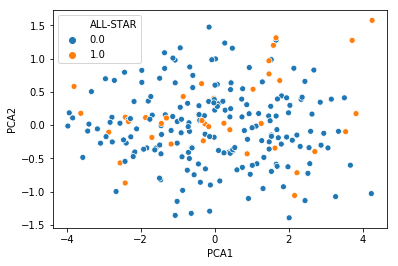

In [17]:
sns.scatterplot(x="PCA1", y="PCA2", hue="ALL-STAR", data=principalDf)

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  import sys
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoid

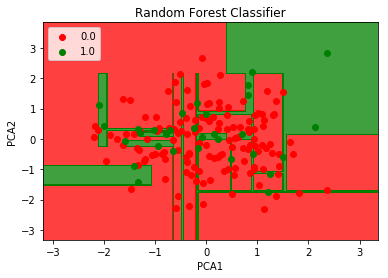

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


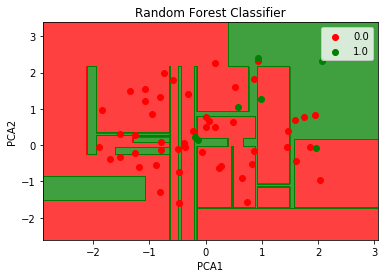

In [20]:
#Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(principalDf[['PCA1', 'PCA2']], principalDf['ALL-STAR'], test_size = 0.25, random_state = 0)

# Feature Scaling
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Decision Tree Classification to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Random Forest Classifier')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

# Visualising the Test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Random Forest Classifier')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

## Conclusion

We have created two classification models. One that uses Wingspan and Height to predict All-Star selection. Another that uses Wingspan, Height, Standing Reach, and Weight to predict All-Star selection. 

Notice we do have a lot of false negatives. This is expected, as we took in all All-Star selections in NBA History. So players like Kyle Korver or Jeff Teague are playing average or below right now. But they made the All-Stars in 2015, so that was included in this data set. This data was included because we want to take into account all players' wingspans and measurements in the all-star selection. 